In [1]:
import os, sys; sys.path.append(os.path.join(os.getcwd(), 'MoGe'))
import cv2
import time
import random
import numpy as np
import open3d as o3d
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt 

from Puzzles.puzzles_utils import generate_overlapping_boxes, estimate_camera_pose_ransac, \
                                  random_rotate, calibrate_intrinsics_by_pts
from Puzzles.visualization import visualize_boxes, rasterization, VisOpen3D, puzzles_visibility_on_canvas, visualize_puzzles_regions
from MoGe import utils3d

# visualize camera
def vis_camera(width, height, points, image, puzzles_extrinsics, puzzles_intrinsics, mask, bbox_colors):
    vis = VisOpen3D(width=width, height=height, visible=True)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points.reshape(-1, 3)[mask.reshape(-1)])
    pcd.colors = o3d.utility.Vector3dVector(image.reshape(-1, 3)[mask.reshape(-1)] / 255)
    vis.add_geometry(pcd)
    for cam_id, (extrinsic, intrinsic) in enumerate(zip(puzzles_extrinsics, puzzles_intrinsics)):
        vis.draw_camera(intrinsic, extrinsic, 
                        color=np.array(bbox_colors[cam_id])[...,::-1]/255, # matplotlib color is in RGB, open3d color is in BGR
                        scale=0.5) 
    vis.run()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Run the following code to generate points and intrinsic parameters for Image-to-Clips

In [2]:
# !python MoGe/infer.py --input examples/I2C/indoor.jpg --output examples/I2C/  --threshold 0.01 --maps
# !python MoGe/infer.py --input examples/I2C/mouse.jpg --output examples/I2C/  --threshold 0.02 --maps
# python MoGe/infer.py --input examples/I2C/moountaint.jpg --output output/I2C/  --threshold 0.02 --maps


### Image-to-Clips
#### 1. Initialize the parameters

In [3]:

random_seed = np.random.randint(10)
rng = np.random.default_rng(random_seed)
# --- Parameters for Image-to-Clips ---#
# --- Patch generation parameters --- #
NBox = 10 # Number of patches to generate
min_box_size_scale = 0.3 # Minimum patch size scale in percentage
max_box_size_scale = 0.6 # Maximum patch size scale in percentage
min_overlap = 0.1 # Minimum overlap between patches in percentage 
max_overlap = 0.3 # Maximum overlap between patches in percentage 

# --- Augmentation parameters --- # 
IfRotate=True 
rotate_ratio = 0.2 # Probability of rotating the patch
rotate_min_coverage = 0.2 # Minimum coverage of the patch after rotation
rotate_max_coverage = 0.8 # Maximum coverage of the patch after rotation
max_rotation_angle = 30.0 # Rotation angle in degrees
front_back_ratio_thresh = 0.6
root = Path(r'examples/I2C/indoor')

image_path = root / 'image.jpg'
mask_path = root / 'mask.png'
ori_intrinsics_path = root / 'intrinsics.npy'
pcd_path = root / 'points.ply'
I2C_bbox_path = root / 'I2C' / 'Image2Clips_wo_Rot.png'
I2C_region_path = root / 'I2C' / 'Image2Clips_wo_Rot_region.png'
I2C_rot_region_path = root / 'I2C' / 'Image2Clips_w_Rot_region.png'


image = cv2.imread(str(image_path))
height, width, _ = image.shape
point_mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED).astype(np.bool_)
intrinsics = np.load(ori_intrinsics_path)
pcd = o3d.io.read_point_cloud(str(pcd_path))
points = np.array(pcd.points).reshape(height, width, 3)

#### 2. Generate ordered overlapping patches

Time taken to generate patches: 0.22 seconds
Overlap between B 1 and B 2: 0.15, B 3: 0.00, B 4: 0.18, B 5: 0.07, B 6: 0.00, B 7: 0.00, B 8: 0.00, B 9: 0.00, B 10: 0.00
Overlap between B 2 and B 1: 0.15, B 3: 0.17, B 4: 0.04, B 5: 0.11, B 6: 0.00, B 7: 0.00, B 8: 0.00, B 9: 0.00, B 10: 0.00
Overlap between B 3 and B 1: 0.00, B 2: 0.17, B 4: 0.00, B 5: 0.06, B 6: 0.15, B 7: 0.00, B 8: 0.00, B 9: 0.00, B 10: 0.00
Overlap between B 4 and B 1: 0.18, B 2: 0.04, B 3: 0.00, B 5: 0.23, B 6: 0.00, B 7: 0.29, B 8: 0.00, B 9: 0.00, B 10: 0.00
Overlap between B 5 and B 1: 0.07, B 2: 0.11, B 3: 0.06, B 4: 0.23, B 6: 0.02, B 7: 0.29, B 8: 0.00, B 9: 0.04, B 10: 0.00
Overlap between B 6 and B 1: 0.00, B 2: 0.00, B 3: 0.15, B 4: 0.00, B 5: 0.02, B 7: 0.00, B 8: 0.28, B 9: 0.13, B 10: 0.28
Overlap between B 7 and B 1: 0.00, B 2: 0.00, B 3: 0.00, B 4: 0.29, B 5: 0.29, B 6: 0.00, B 8: 0.00, B 9: 0.00, B 10: 0.00
Overlap between B 8 and B 1: 0.00, B 2: 0.00, B 3: 0.00, B 4: 0.00, B 5: 0.00, B 6: 0.28, B 7:

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2048, 1365) to (2048, 1376) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


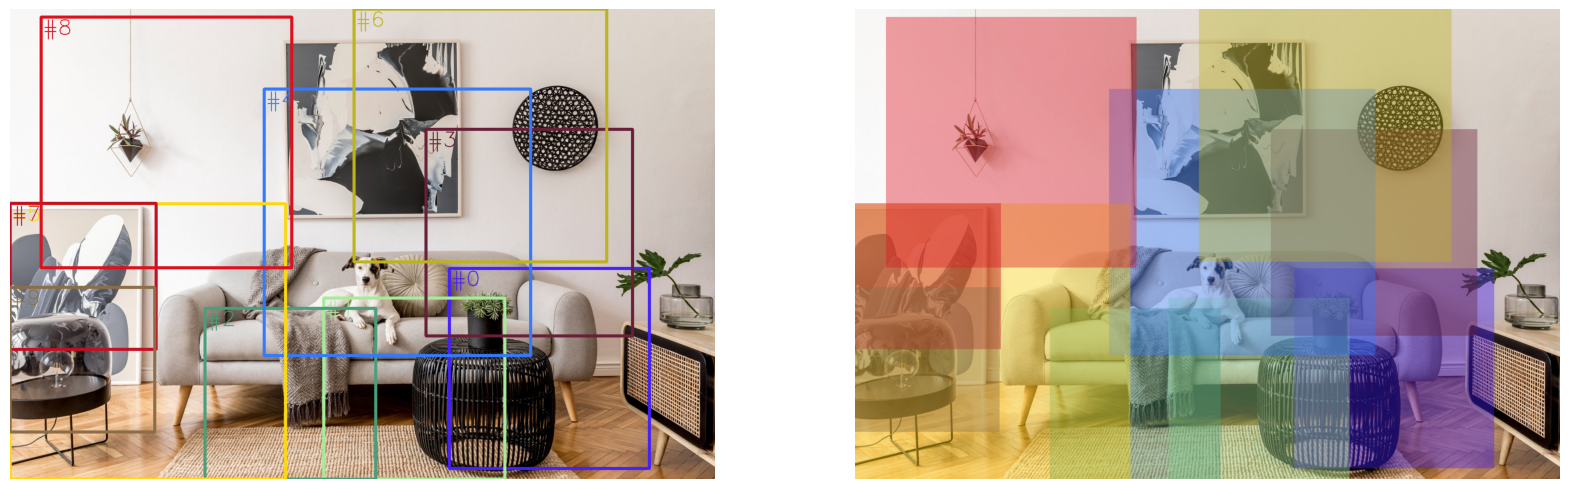

In [4]:
t0 = time.time()
boxes, template_box = generate_overlapping_boxes(
    image=image,
    mask=point_mask,
    n_boxes=NBox,
    min_box_size_scale=min_box_size_scale,
    max_box_size_scale=max_box_size_scale,
    min_overlap=min_overlap,
    max_overlap=max_overlap,
    max_attempts=1000,
    rng=rng,
)
print(f"Time taken to generate patches: {time.time() - t0:.2f} seconds")

bbox_colors = visualize_boxes(image, boxes, I2C_bbox_path)
# opencv: bgr to rgb color
bbox_colors_rgb = [color[::-1] for color in bbox_colors]
visualize_puzzles_regions(image=image[..., ::-1], boxes=boxes, puzzle_colors=bbox_colors_rgb, save_path=I2C_region_path, alpha_ratio=0.4, save_per_frame=True)
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(Image.open(I2C_bbox_path))
plt.axis('off')
plt.subplot(122)
plt.imshow(Image.open(I2C_region_path))
plt.axis('off')
plt.show()

#### 3. Calibation

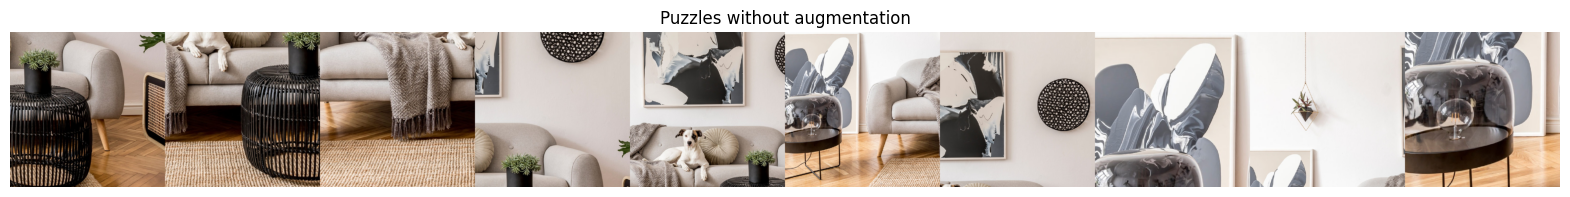

In [5]:
# Intrinsics
'''
# All patches use the same camera intrinsics.
# Note: We use the template box and points to calibrate the camera intrinsics, which is not perfect but enough for visualization.
# For the properly corrected intrinsics, please refer to the training code.
'''

templ_box_h, templ_box_w = template_box[3] - template_box[1], template_box[2] - template_box[0]
boxK, _, _ = calibrate_intrinsics_by_pts(template_box, points)
# Extrinsics
puzzles = []
puzzles_boxes = []
puzzles_masks = []
puzzles_points = []
puzzles_depths = []
puzzles_intrinsics = [] 
puzzles_extrinsics = []
calib_num_pts = 1024
for b_i, bbox in enumerate(boxes):
    tm = time.time()
    box_h, box_w = bbox[3] - bbox[1], bbox[2] - bbox[0]
    box_points = points[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    box_mask = point_mask[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    box_image = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    box_depths = box_points[..., 2]
    
    if box_h != templ_box_h or box_w != templ_box_w:
        # resize box_points to the same size as the template box
        box_points = cv2.resize(box_points, (templ_box_w, templ_box_h), interpolation=cv2.INTER_NEAREST)
        box_mask = cv2.resize(box_mask.astype(np.uint8), (templ_box_w, templ_box_h), interpolation=cv2.INTER_NEAREST).astype(np.bool_)
        box_image = cv2.resize(box_image, (templ_box_w, templ_box_h), interpolation=cv2.INTER_NEAREST)
        box_depths = cv2.resize(box_depths, (templ_box_w, templ_box_h), interpolation=cv2.INTER_NEAREST)
  
    box_uv = utils3d.numpy.image_pixel_center(templ_box_w, templ_box_h)
    box_uv_ds = box_uv.reshape(-1, 2)
    mask_ds = box_mask.reshape(-1)
    box_points_ds = box_points.reshape(-1, 3) 
    if np.sum(mask_ds) > calib_num_pts:
        idx = rng.choice(np.arange(mask_ds.shape[0])[mask_ds], calib_num_pts, replace=False)
        box_points_ds_sm = box_points_ds[idx]
        box_uv_ds_sm = box_uv_ds[idx]
        mask_sm = mask_ds[idx]
    try:
        w2c, _, _ = estimate_camera_pose_ransac(box_points_ds_sm[mask_sm], box_uv_ds_sm[mask_sm], boxK)
        
    except:
        print(f"Failed to estimate camera pose for box {b_i}")
    
    puzzles.append(box_image)
    puzzles_boxes.append(bbox)
    puzzles_masks.append(box_mask)
    puzzles_points.append(box_points)
    puzzles_depths.append(box_depths)
    puzzles_intrinsics.append(boxK)
    puzzles_extrinsics.append(w2c)
    
    cv2.imwrite(root / 'I2C' / f'puzzle_{b_i}.png', box_image)

# visualize concatenated puzzles
puzzles_vis = np.concatenate(puzzles, axis=1)
cv2.imwrite(root / 'I2C' / 'puzzle_all.png', puzzles_vis)
plt.figure(figsize=(20, 5))
plt.title('Puzzles without augmentation')
plt.imshow(puzzles_vis[..., ::-1])
plt.axis('off')
plt.show()

# visualize the puzzles on the original image
vis_image = image.copy()
canvas = np.ones_like(image) * 255
for b_i, bbox in enumerate(puzzles_boxes):
    cv2.rectangle(vis_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), bbox_colors[b_i], 4)
    text_pos = (bbox[0]+5, bbox[1]+50)
    cv2.putText(vis_image, f'#{b_i}', text_pos,
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4)
    cv2.imwrite(root / 'I2C' / f'puzzle_{b_i}_bbox.png', vis_image)
    canvas[bbox[1]:bbox[3], bbox[0]:bbox[2]] = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    cv2.imwrite(root / 'I2C' / f'puzzle_{b_i}_canvas.png', canvas)



In [6]:
# You can comment out the below code for camera visualization
# vis_camera(width=templ_box_w, height=templ_box_h,
#            points=points, image=image[...,::-1], 
#            puzzles_extrinsics=puzzles_extrinsics, 
#            puzzles_intrinsics=puzzles_intrinsics, 
#            mask=point_mask,
#            bbox_colors=bbox_colors)

#### 4. Augmentation

Rotation :  [False, True, True, False, True, False, False, True, False, True]


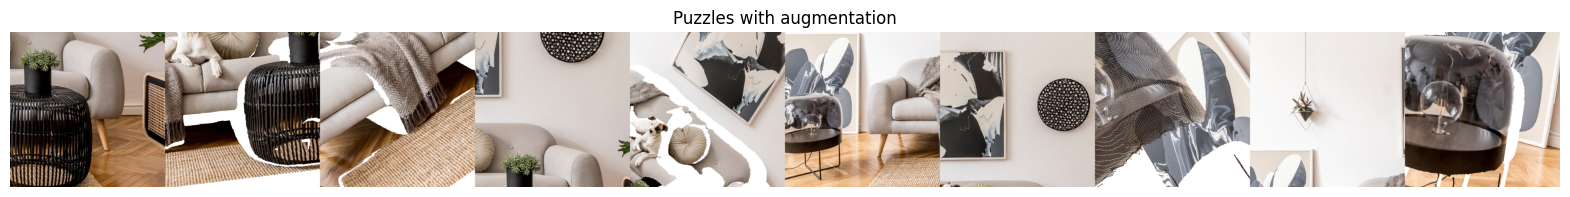

In [7]:
rot_puzzles_extrinsics = []
rot_or_not = []
for pi, (intrinsic, extrinsic) in enumerate(zip(puzzles_intrinsics, puzzles_extrinsics)):
    if np.random.rand() > rotate_ratio:
    
        # Randomly rotate the puzzle
        rot_extrinsic = random_rotate(points=puzzles_points[pi],
                  masks=puzzles_masks[pi],
                  intrinsic=intrinsic,
                  extrinsic=extrinsic,
                  width=templ_box_w,
                  height=templ_box_h,
                  max_rotation_angle=max_rotation_angle,
                  min_coverage=rotate_min_coverage,
                  max_coverage=rotate_max_coverage,
                  front_back_ratio_thresh=front_back_ratio_thresh,
                  rng=rng,
                  max_tries=3,
                  vis_canvas=False
                  )
        
        rot_puzzles_extrinsics.append(rot_extrinsic)
        rot_or_not.append(True)
    else:
        rot_extrinsic = extrinsic
        rot_puzzles_extrinsics.append(rot_extrinsic)
        rot_or_not.append(False)

render_images, render_depths = rasterization(points=points.reshape(-1,3),
                                           colors=image.reshape(-1,3),
                                           mask=point_mask.reshape(-1),
                                           intrinsics=puzzles_intrinsics,
                                           extrinsics=rot_puzzles_extrinsics,
                                           width=templ_box_w,
                                           height=templ_box_h,
                                           bg_color=(1, 1, 1))
print("Rotation : ", rot_or_not)
# # Update the puzzles
for pi, rot_ in enumerate(rot_or_not):
    if rot_:
        depth = render_depths[pi]
        puzzle_mask = depth > 0
        puzzle_points = utils3d.numpy.unproject_cv(utils3d.numpy.image_uv(width=templ_box_w, height=templ_box_h, dtype=depth.dtype), depth, extrinsics=puzzles_extrinsics[pi], intrinsics=puzzles_intrinsics[pi])
        puzzles_points[pi] = puzzle_points.reshape(templ_box_h, templ_box_w, 3)
        puzzles_masks[pi] = puzzle_mask.reshape(templ_box_h, templ_box_w)
        puzzles[pi] = render_images[pi]
    
    cv2.imwrite(root / 'I2C' / f'rot_puzzle_{pi}.png', puzzles[pi])

# visualize concatenated rotated puzzles
puzzles_vis = np.concatenate(puzzles, axis=1)
cv2.imwrite(root / 'I2C' / 'rot_puzzle_all.png', puzzles_vis)
plt.figure(figsize=(20, 5))
plt.title('Puzzles with augmentation')
plt.imshow(puzzles_vis[..., ::-1])
plt.axis('off')
plt.show()

# visualize the puzzles on the original image
canvas_masks = puzzles_visibility_on_canvas(points = points, 
                             masks=point_mask,
                             intrinsics=puzzles_intrinsics,
                             extrinsics=rot_puzzles_extrinsics,
                             height=templ_box_h,
                             width=templ_box_w,
                             )

vis_image = image.copy()
canvas = np.ones_like(image) * 255
for b_i, canvas_mask in enumerate(canvas_masks):
    canvas_mask = canvas_mask.reshape(height, width)
    canvas[canvas_mask] = image[canvas_mask]
    cv2.imwrite(root / 'I2C' / f'rot_puzzle_{b_i}_canvas.png', canvas)
    


In [8]:
# visualize the augmented puzzles on the original image
visualize_puzzles_regions(image=image[..., ::-1], masks=canvas_masks, puzzle_colors=bbox_colors_rgb, save_path=I2C_rot_region_path, alpha_ratio=0.4, save_per_frame=True)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2048, 1365) to (2048, 1376) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [9]:
vis_camera(width=templ_box_w, height=templ_box_h,
           points=points, image=image[...,::-1], 
           puzzles_extrinsics=puzzles_extrinsics, 
           puzzles_intrinsics=puzzles_intrinsics, 
           mask=point_mask,
           bbox_colors=bbox_colors,
           )

results = {
    'points': points,
    'image': image,
    'mask': point_mask,
    'puzzles_extrinsics': puzzles_extrinsics,
    'puzzles_intrinsics': puzzles_intrinsics,
    'rot_puzzles_extrinsics': rot_puzzles_extrinsics,
    'bbox_colors':bbox_colors
}

np.save(root / 'I2C' / 'I2C_results.npy', results)
print("I2C generation completed. Results saved to:", root / 'I2C' / 'I2C_results.npy')

I2C generation completed. Results saved to: examples/I2C/indoor/I2C/I2C_results.npy
